In [ ]:

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import helper_functions as hf

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_blockchain = pd.read_csv("df_blockchain.csv", delimiter=",")
# get columns (You can add more columns to analyse results)
columns = ["market-price"]
dataset = df_blockchain[columns]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))
# split datatest into data_train, data_valid and data_test

data_train = dataset[:3000]
data_valid = dataset[3000:-30]
data_test = dataset[-30:]
rnn_size = 3
def process_data(data, rnn_size, target_id=0, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)
    # process data for RNN
X_train, y_train = process_data(data_train,rnn_size)
X_val, y_val = process_data(data_valid,rnn_size)
X_test, y_test = process_data(data_test,rnn_size)
data_sets = [y_train, y_val, y_test]
for set in data_sets :
    set = set.reshape(len(set), 1)

In [ ]:
# LSTM + Dense model

# Parameters

h1 = 50 # Size of LSTM layer
lambda2=0.00001

# Build the models

model_names = ['lstm', 'stk_lstm', 'dd_lstm']
model_list = []

## LSTM model

lstm = keras.Sequential()
lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True, input_shape = (X_train.shape[1], 1)))
lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
model_list.append(lstm)

## Stacked-LSTM model

stk_lstm = keras.Sequential()
stk_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True, input_shape = (X_train.shape[1], 1)))
stk_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2), return_sequences=True))
stk_lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
model_list.append(stk_lstm)

## Double-dense-LSTM model

dd_lstm = keras.Sequential()
dd_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2)))
dd_lstm.add(layers.Dense(10,kernel_regularizer = regularizers.l2(lambda2)))
dd_lstm.add(layers.Dense(1, kernel_regularizer = regularizers.l2(lambda2), activation = 'relu'))
model_list.append(stk_lstm)

# ## Attention-LSTM model

# att_lstm = keras.Sequential()
# att_lstm.add(layers.LSTM(h1, kernel_regularizer = regularizers.l2(lambda2)))
# att_lstm.add(layers.Attention())
# model_list.append(att_lstm)

In [ ]:
# N times fit of the models to determine a mean loss for each one

N = 10

start_time = datetime.now()

rmse_list = []

for i in range(N):
  print(f'{i+1}-th iteration ...')
  rmse_mod = []
  for model in model_list: 
    # Fit the models
    model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam())
    model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_data = (X_val, y_val), verbose = 0)

    # Compute the RMSE
    y_pred = model.predict(X_test)
    y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred.reshape(len(y_pred),rnn_size), data_test[-len(y_pred):,:]], axis=1))
    y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]
    rmse_score = np.sqrt(np.mean((y_pred_inverse - y_test_inverse)**2))
    rmse_mod.append(rmse_score)
  rmse_list.append(rmse_mod)

rmse_list = np.array(rmse_list)

print('Time to compute (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))


1-th iteration ...
2-th iteration ...
3-th iteration ...
4-th iteration ...
5-th iteration ...
6-th iteration ...
7-th iteration ...
8-th iteration ...
9-th iteration ...
10-th iteration ...
Time to compute (hh:mm:ss.ms) 0:21:57.083535


Mean RMSE for lstm =  RMS: 5286.25$
Mean RMSE for stk_lstm =  RMS: 14011.97$
Mean RMSE for dd_lstm =  RMS: 14140.23$


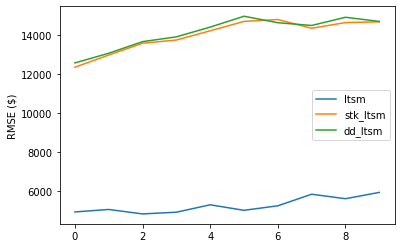

In [ ]:
rmse_list

for i in range(3) :
  print(f'Mean RMSE for {model_names[i]} = ', 'RMS: {:.2f}$'.format(np.mean(rmse_list[:,i])))

plt.plot(rmse_list[:,0], label='ltsm')
plt.plot(rmse_list[:,1], label='stk_ltsm')
plt.plot(rmse_list[:,2], label='dd_ltsm')
plt.ylabel("RMSE ($)")
plt.legend()
plt.show()